## Paul's draft of the IACS 2019 interpretability + fairness workshop

In [173]:
# Imports
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import eqtools as eq 

sns.set_palette('Set3', color_codes=True)
%matplotlib inline

Using TensorFlow backend.


## Load the data
- TODO decide on the dataset and the workflow for both the interp section and the fairness section

In [48]:
def find_corr_feats(df, thresh=0.95):
    """ Function to drop linearly correalated features above a threshold of correlation 
    --------
    Args:
        df (pandas dataframe): DataFrame with at least two quantitative features
        thresh (float): the threshold of absolute pearson correlation to drop features above
    --------
    Returns: 
        (list) the feature names to drop 
    """
    # Correlation matrix
    corr_matrix = df.corr().abs()

    # Select upper triangle of correlation matrix and find columns
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    
    # Find cols to drop 
    to_drop = [column for column in upper.columns if any(upper[column] > thresh)]
    return to_drop

"""top_feats = ['loan_amnt', 'term', 'int_rate', 'annual_inc', 'dti', 'fico_range_low',
       'mths_since_last_delinq', 'open_acc', 'revol_bal', 'revol_util',
       'total_acc']+['grade', 'emp_length', 'home_ownership', 'verification_status',\
        'zip_code','disbursement_method']
new_df2 = new_df[top_feats].copy(deep=True)
new_df2.isnull()"""

to_drop = find_corr_feats(df, thresh=0.9)
new_df = df.drop(to_drop, axis=1)

"""from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

s_df = new_df.sample(int(len(new_df)*.2), random_state=42)
df_x = s_df.drop(list(df.dtypes[df.dtypes==object].index)+['loan_status'], axis=1)
df_y = s_df['loan_status']

xtr, xte, ytr, yte = train_test_split(df_x, df_y, test_size=0.33, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
sfm = SelectFromModel(clf, threshold='median')
sfm.fit(xtr, ytr)

df_x.columns[sfm.get_support(indices=True)]"""

## Load the (relatively) cleaned data

In [166]:
# Import cleaned data
df = pd.read_csv('../data/loans_data.csv')
print(f'We have {len(df)} rows.')
df.head()

We have 805148 rows.


,loan_amnt,int_rate,annual_inc,dti,delinq_2yrs,fico_range_low,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,...,emp_length,home_ownership,verification_status,zip_code,term,initial_list_status,disbursement_method,application_type,loan_status,ago_of_cr_line
0,5000.0,0.1065,24000.0,27.65,0.0,735.0,1.0,34.446551,70.816146,3.0,...,10+ years,RENT,Verified,860xx,36,f,Cash,Individual,1,33.0
1,2500.0,0.1527,30000.0,1.00,0.0,740.0,5.0,34.446551,70.816146,3.0,...,< 1 year,RENT,Source Verified,309xx,60,f,Cash,Individual,0,19.0
2,2400.0,0.1596,12252.0,8.72,0.0,735.0,2.0,34.446551,70.816146,2.0,...,10+ years,RENT,Not Verified,606xx,36,f,Cash,Individual,1,17.0
3,10000.0,0.1349,49200.0,20.00,0.0,690.0,1.0,35.000000,70.816146,10.0,...,10+ years,RENT,Source Verified,917xx,36,f,Cash,Individual,1,22.0
4,3000.0,0.1269,80000.0,17.94,0.0,695.0,0.0,38.000000,70.816146,15.0,...,1 year,RENT,Source Verified,972xx,60,f,Cash,Individual,1,22.0


### Seperate out into train and test

In [167]:
# One hot encoding and subset into train/test 
quant_cols = ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low',\
              'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec',\
              'revol_bal', 'revol_util', 'total_acc', 'policy_code', 'acc_now_delinq', 'tot_coll_amt',\
              'tot_cur_bal', 'tax_liens', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit',\
              'ago_of_cr_line', 'installment']

cat_cols = ['grade','emp_length', 'home_ownership','verification_status', 'term', 'initial_list_status',\
            'disbursement_method', 'application_type']

other_cols = ['zip_code']
response_col = 'loan_status'

df_x = pd.get_dummies(df[quant_cols+cat_cols], drop_first=True, columns=cat_cols)
df_y = df[response_col]

x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.3, random_state=42)

In [ ]:
import eqtools as eq
import importlib as imp
imp.reload(eq)
import eqtools as eq
%load_ext autoreload
%autoreload 2

In [180]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=0.1, solver='liblinear').fit(x_train, y_train)

Accuracy Train: 0.7961; Accuracy Test: 0.7969
AUC train: 0.6471; AUC test: 0.6493


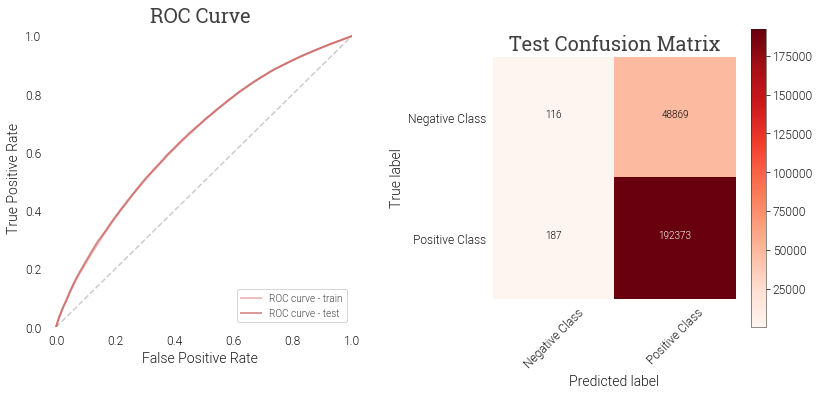

In [225]:
print(f'Accuracy Train: {round(lr.score(x_train, y_train),4)}; Accuracy Test: {round(lr.score(x_test, y_test),4)}')

eq.model.model_analysis(lr, x_train, y_train, x_test, y_test, style='deck', figsize=(12,6));

In [179]:
# x_train.isnull().sum()

In [77]:
sfm.get_support(indices=True)

array([ 0,  1,  2,  3,  4,  6,  8, 10, 12, 13, 14, 19, 31, 35, 36, 37, 38,
       40, 41, 42, 43, 45, 47, 51, 52, 53, 54, 55, 56, 61, 62, 65, 66, 67])

## Create a simple model 
- Use a GBM or something that overfits and models sensible structure in the data poorly


## Apply Interp methods 
- Use LIME and Input Gradients to determine that the model is bad

## Deeper dive into LIME and Input Gradients 
- How do these methods look theoretically? 
- What do they mean practically and how should we use the results to inform model building?
- Look quickly at [SHAP values](http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions.pdf) for theoretical side and systhesis 

## Make a model that passes interp tests 
- Create model and validate with interp methods that it is making good assumptions about the structure of the data 

## Apply Interp and verify the model passes

## Fairness! 
- Although a model is well-founded and predicts well, it can still be biased without us knowing
- There are several ways to measure the fairness of a model
